In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import count
from pyspark.sql.types import *

##Prepare the data

In [0]:
# Creating the schema for posttypes and users tables
PT_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("Type", StringType(), True)
])

users_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("Age", IntegerType(), True),
    StructField("CreationDate", DateType(), True),
    StructField("DisplayName", StringType(), True),
    StructField("DownVotes", IntegerType(), True),
    StructField("EmailHash", StringType(), True),
    StructField("Location", StringType(), True),
    StructField("Reputation", IntegerType(), True),
    StructField("UpVotes", IntegerType(), True),
    StructField("Views", IntegerType(), True),
    StructField("WebsiteUrl", StringType(), True),
    StructField("AccountId", IntegerType(), True)
])

# creating the dataframe for both posttype and users
postType = (spark.read
  .option("header", "true")
  .option("sep", ",")
  .schema(PT_schema)
  .csv("/mnt/deBDProject/project/postTypes/"))

users = (spark.read
  .option("header", "true")
  .option("sep", ",")
  .schema(users_schema)
  .csv("/mnt/deBDProject/project/Users/"))

# load and create posts dataframe
posts = spark.read.parquet("/mnt/deBDProject/project/Posts/*")
posts_df = posts.join(postType, posts.PostTypeId == postType.id)

# join users with posts
users_df = posts.join(postType, posts.PostTypeId == postType.id).join(users, posts.OwnerUserId == users.AccountId)

### Analysis 1: Answered Questions vs Not Answered (Pie Chart)

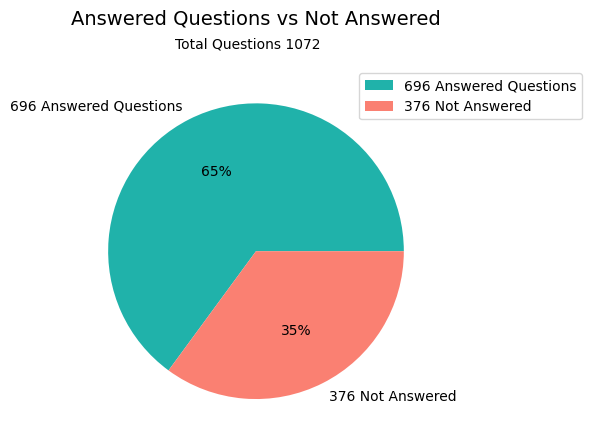

In [0]:
# Get Questions column and count
questions = posts_df.filter(posts_df.Type == 'Question')
questions_count = questions.count()

# Get the number of answered questions and not
answered_questions = questions.filter(posts_df.AcceptedAnswerId != 0).count()
not_answered = questions.filter(posts_df.AcceptedAnswerId == 0).count()

# label values
pie_label1 = f"{answered_questions} Answered Questions"
pie_label2 = f"{not_answered} Not Answered"

# Create the pie chart
pie_lables = [pie_label1, pie_label2]
pie_values = [answered_questions, not_answered]
colors_list = ['lightseagreen', 'salmon', 'cadetblue']
pie_subtitle = f"Total Questions {questions_count}"

plt.pie(pie_values, labels = pie_lables, autopct='%1.0f%%', labeldistance=1.1, colors = colors_list)
plt.legend(loc="upper right", bbox_to_anchor=(1, 0, 0.4, 1))
plt.title(label="Answered Questions vs Not Answered", fontsize=14, pad=30)
plt.suptitle(pie_subtitle, y=0.94, fontsize=10)
plt.show() 

### Analysis 2: Top Active Users (bar Chart)

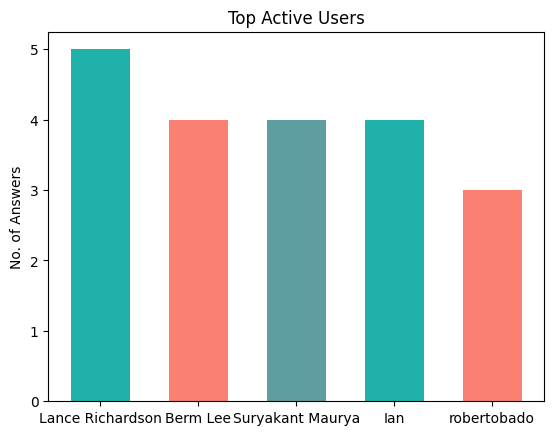

In [0]:
# Active users
active_users = users_df.filter("Type == 'Answer'").filter("OwnerUserId != 0 and OwnerUserId != -1").groupBy("OwnerUserId", "DisplayName").count().filter("count > 2").orderBy("count", ascending=False)

active_users = active_users.limit(5)
active_users_toPandas = active_users.toPandas()

plt.bar(active_users_toPandas['DisplayName'], active_users_toPandas['count'], color =colors_list, width = 0.6)
plt.ylabel("No. of Answers")
plt.title("Top Active Users")
plt.show()

### Analysis 3: Users with Most Reputation Score (bar Chart)

what is Reputation <https://stackoverflow.com/help/whats-reputation>

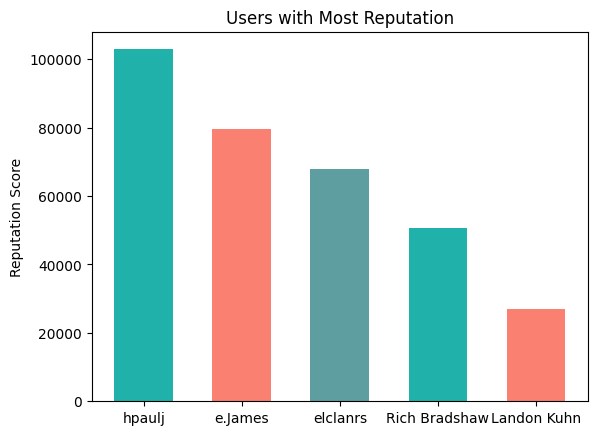

In [0]:
users_rep = users_df.select("Reputation", "DisplayName").orderBy("Reputation", ascending=False).limit(5)
users_rep_toPandas = users_rep.toPandas()

plt.bar(users_rep_toPandas['DisplayName'], users_rep_toPandas['Reputation'], color =colors_list, width = 0.6)
plt.ylabel("Reputation Score")
plt.title("Users with Most Reputation")
plt.show()

#Dashboard

###Visulation 1 - Answered Questions vs Not Answered

In [0]:
vis1 = [['Answered Questions', answered_questions], ['Not Answered', not_answered]]
v1_df = pd.DataFrame(vis1, columns=['Type', 'Count'])
display(v1_df)

Type,Count
Answered Questions,696
Not Answered,376


Databricks visualization. Run in Databricks to view.

###Visulation 2 - Top Active Users

In [0]:
display(active_users_toPandas)

OwnerUserId,DisplayName,count
9833,Lance Richardson,5
267025,Berm Lee,4
1347008,Suryakant Maurya,4
1151902,Ian,4
1209279,robertobado,3


Databricks visualization. Run in Databricks to view.

###Visulation 3 - Users with Most Reputation Score

In [0]:
display(users_rep_toPandas)

Reputation,DisplayName
102862,hpaulj
79561,e.James
67861,elclanrs
50649,Rich Bradshaw
27070,Landon Kuhn


Databricks visualization. Run in Databricks to view.

##EDA 1 - Number of Posts


In [0]:
# Get the count of posts
post_count = posts_df.count()

# Convert the post count to a pandas DataFrame
post_count_df = pd.DataFrame({'Number of posts': [post_count]})

# Display the post count as a visualization
display(post_count_df)

Number of posts
2025


Databricks visualization. Run in Databricks to view.

## EDA 2  - Number of Users

In [0]:
# Get the count of users
user_count = users_df.count()

# Convert the user count to a pandas DataFrame
user_count_df = pd.DataFrame({'Number of users': [user_count]})

# Display the user count as a visualization
display(user_count_df)

Number of users
1142


Databricks visualization. Run in Databricks to view.

## EDA 3 - Most Viewed Post Views

In [0]:
from pyspark.sql.functions import desc

# Get the count of the most viewed post
most_viewed_post = posts_df.orderBy(desc("ViewCount")).first()
view_count = most_viewed_post.ViewCount

# Convert the view count to a pandas DataFrame
view_count_df = pd.DataFrame({'Most Viewed Post Views': [view_count]})

# Display the view count as a visualization
display(view_count_df)

Most Viewed Post Views
168835


Databricks visualization. Run in Databricks to view.